## C. Find Fast implementations on net (python, C or any other language)

### 4. Implement or At least Run it

#### Using Linear Seperable Convolution

(120, 213)


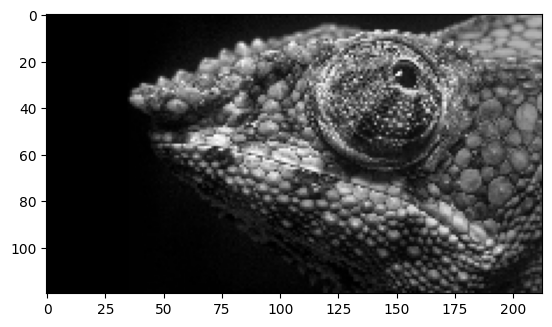

(120, 213)


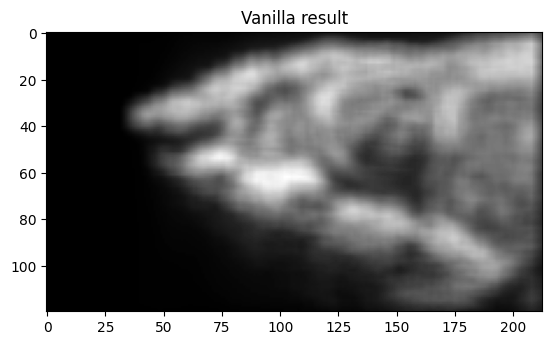

(120, 213)


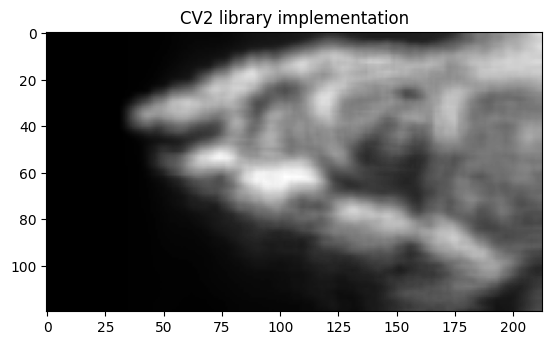

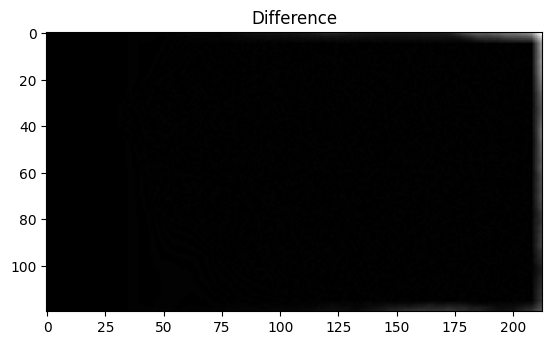

Vanilla Implementation: 0.11501526832580566 (Python)
Library Result: 0.00011491775512695312 (C)
Difference: 0.11490035057067871


In [110]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from time import time

def convolve_1d(signal, kernel):
    signal_len = len(signal)
    kernel_len = len(kernel)
    padding = kernel_len // 2
    padded_signal = np.pad(signal, (padding, padding), mode='constant')
    result = np.zeros(signal_len)
    
    for i in range(signal_len):
        result[i] = np.sum(padded_signal[i:i+kernel_len] * kernel)
    
    return result

def separable_moving_average_convolution(image, matrsize):
    # create 1D kernel for moving average
    kernel_1d = np.ones(matrsize, dtype=np.float32) / matrsize

    # apply horizontal convolution
    rows, cols = image.shape
    intermediate = np.zeros_like(image, dtype=np.float32)
    for i in range(rows):
        intermediate[i, :] = convolve_1d(image[i, :].astype(np.float32), kernel_1d)
    
    # apply vertical convolution
    result = np.zeros_like(image, dtype=np.int64)
    for j in range(cols):
        result[:, j] = convolve_1d(intermediate[:, j], kernel_1d)

    return result

org = cv2.imread('../../images/chameleon.jpg')
greyorg = cv2.cvtColor(org, cv2.COLOR_BGR2GRAY)

greyorg_resized = cv2.resize(greyorg, (greyorg.shape[1]//18,greyorg.shape[0]//18))
print(greyorg_resized.shape)

matrsize = 10

# apply separable convolution
start = time()
vanilla_result = separable_moving_average_convolution(greyorg_resized, matrsize)
vanilla_time = time() - start

# apply cv2.blur
start = time()
cv2blurred_result = cv2.blur(greyorg_resized, (matrsize, matrsize))
library_time = time() - start

difference = np.abs(vanilla_result.astype(np.int64) - cv2blurred_result.astype(np.int64))

# Display results
plt.imshow(greyorg_resized, cmap='gray')
plt.show()
print(vanilla_result.shape)
plt.imshow(vanilla_result.astype(np.int64), cmap='gray')
plt.title("Vanilla result")
plt.show()
print(cv2blurred_result.shape)
plt.imshow(cv2blurred_result, cmap='gray')
plt.title("CV2 library implementation")
plt.show()
plt.imshow(difference,cmap='gray')
plt.title("Difference")
plt.show()

print("Vanilla Implementation:",vanilla_time,"(Python)")
print("Library Result:",library_time,"(C)")
print("Difference:",vanilla_time-library_time)

### Implementation of FFT convolution in Pytorch
reference: https://github.com/fkodom/fft-conv-pytorch

In [111]:
# Fast FFT 2D convolution implementation in PyTorch

from functools import partial
from typing import Iterable, Tuple, Union

import torch
import torch.nn.functional as f
from torch import Tensor, nn
from torch.fft import irfftn, rfftn
from math import ceil, floor


def complex_matmul(a: Tensor, b: Tensor, groups: int = 1) -> Tensor:
    """Multiplies two complex-valued tensors."""
    # Scalar matrix multiplication of two tensors, over only the first channel
    # dimensions. Dimensions 3 and higher will have the same shape after multiplication.
    # We also allow for "grouped" multiplications, where multiple sections of channels
    # are multiplied independently of one another (required for group convolutions).
    a = a.view(a.size(0), groups, -1, *a.shape[2:])
    b = b.view(groups, -1, *b.shape[1:])

    a = torch.movedim(a, 2, a.dim() - 1).unsqueeze(-2)
    b = torch.movedim(b, (1, 2), (b.dim() - 1, b.dim() - 2))

    # complex value matrix multiplication
    real = a.real @ b.real - a.imag @ b.imag
    imag = a.imag @ b.real + a.real @ b.imag
    real = torch.movedim(real, real.dim() - 1, 2).squeeze(-1)
    imag = torch.movedim(imag, imag.dim() - 1, 2).squeeze(-1)
    c = torch.zeros(real.shape, dtype=torch.complex64, device=a.device)
    c.real, c.imag = real, imag

    return c.view(c.size(0), -1, *c.shape[3:])


def to_ntuple(val: Union[int, Iterable[int]], n: int) -> Tuple[int, ...]:
    """Casts to a tuple with length 'n'.  Useful for automatically computing the
    padding and stride for convolutions, where users may only provide an integer.

    Args:
        val: (Union[int, Iterable[int]]) Value to cast into a tuple.
        n: (int) Desired length of the tuple

    Returns:
        (Tuple[int, ...]) Tuple of length 'n'
    """
    if isinstance(val, Iterable):
        out = tuple(val)
        if len(out) == n:
            return out
        else:
            raise ValueError(f"Cannot cast tuple of length {len(out)} to length {n}.")
    else:
        return n * (val,)


def fft_conv(
    signal: Tensor,
    kernel: Tensor,
    bias: Tensor = None,
    padding: Union[int, Iterable[int], str] = 0,
    padding_mode: str = "constant",
    stride: Union[int, Iterable[int]] = 1,
    dilation: Union[int, Iterable[int]] = 1,
    groups: int = 1,
) -> Tensor:
    """Performs N-d convolution of Tensors using a fast fourier transform, which
    is very fast for large kernel sizes. Also, optionally adds a bias Tensor after
    the convolution (in order ot mimic the PyTorch direct convolution).

    Args:
        signal: (Tensor) Input tensor to be convolved with the kernel.
        kernel: (Tensor) Convolution kernel.
        bias: (Tensor) Bias tensor to add to the output.
        padding: (Union[int, Iterable[int], str) If int, Number of zero samples to pad then
            input on the last dimension. If str, "same" supported to pad input for size preservation.
        padding_mode: (str) Padding mode to use from {constant, reflection, replication}.
                      reflection not available for 3d.
        stride: (Union[int, Iterable[int]) Stride size for computing output values.
        dilation: (Union[int, Iterable[int]) Dilation rate for the kernel.
        groups: (int) Number of groups for the convolution.

    Returns:
        (Tensor) Convolved tensor
    """

    # Cast padding, stride & dilation to tuples.
    n = signal.ndim - 2
    stride_ = to_ntuple(stride, n=n)
    dilation_ = to_ntuple(dilation, n=n)
    if isinstance(padding, str):
        if padding == "same":
            if stride != 1 or dilation != 1:
                raise ValueError("stride must be 1 for padding='same'.")
            padding_ = [(k - 1) / 2 for k in kernel.shape[2:]]
        else:
            raise ValueError(f"Padding mode {padding} not supported.")
    else:
        padding_ = to_ntuple(padding, n=n)

    # internal dilation offsets
    offset = torch.zeros(1, 1, *dilation_, device=signal.device, dtype=signal.dtype)
    offset[(slice(None), slice(None), *((0,) * n))] = 1.0

    # correct the kernel by cutting off unwanted dilation trailing zeros
    cutoff = tuple(slice(None, -d + 1 if d != 1 else None) for d in dilation_)

    # pad the kernel internally according to the dilation parameters
    kernel = torch.kron(kernel, offset)[(slice(None), slice(None)) + cutoff]

    # Pad the input signal & kernel tensors (round to support even sized convolutions)
    signal_padding = [r(p) for p in padding_[::-1] for r in (floor, ceil)]
    signal = f.pad(signal, signal_padding, mode=padding_mode)

    # Because PyTorch computes a *one-sided* FFT, we need the final dimension to
    # have *even* length.  Just pad with one more zero if the final dimension is odd.
    signal_size = signal.size()  # original signal size without padding to even
    if signal.size(-1) % 2 != 0:
        signal = f.pad(signal, [0, 1])

    kernel_padding = [
        pad
        for i in reversed(range(2, signal.ndim))
        for pad in [0, signal.size(i) - kernel.size(i)]
    ]
    padded_kernel = f.pad(kernel, kernel_padding)

    # Perform fourier convolution -- FFT, matrix multiply, then IFFT
    signal_fr = rfftn(signal.float(), dim=tuple(range(2, signal.ndim)))
    kernel_fr = rfftn(padded_kernel.float(), dim=tuple(range(2, signal.ndim)))

    kernel_fr.imag *= -1
    output_fr = complex_matmul(signal_fr, kernel_fr, groups=groups)
    output = irfftn(output_fr, dim=tuple(range(2, signal.ndim)))

    # Remove extra padded values
    crop_slices = [slice(None), slice(None)] + [
        slice(0, (signal_size[i] - kernel.size(i) + 1), stride_[i - 2])
        for i in range(2, signal.ndim)
    ]
    output = output[crop_slices].contiguous()

    # Optionally, add a bias term before returning.
    if bias is not None:
        bias_shape = tuple([1, -1] + (signal.ndim - 2) * [1])
        output += bias.view(bias_shape)

    return output


class _FFTConv(nn.Module):
    """Base class for PyTorch FFT convolution layers."""

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: Union[int, Iterable[int]],
        padding: Union[int, Iterable[int]] = 0,
        padding_mode: str = "constant",
        stride: Union[int, Iterable[int]] = 1,
        dilation: Union[int, Iterable[int]] = 1,
        groups: int = 1,
        bias: bool = True,
        ndim: int = 1,
    ):
        """
        Args:
            in_channels: (int) Number of channels in input tensors
            out_channels: (int) Number of channels in output tensors
            kernel_size: (Union[int, Iterable[int]) Square radius of the kernel
            padding: (Union[int, Iterable[int]) Number of zero samples to pad the
                input on the last dimension. If str, "same" supported to pad input for size preservation.
            padding_mode: (str) Padding mode to use from {constant, reflection, replication}.
                          reflection not available for 3d.
            stride: (Union[int, Iterable[int]) Stride size for computing output values.
            dilation: (Union[int, Iterable[int]) Dilation rate for the kernel.
            groups: (int) Number of groups for the convolution.
            bias: (bool) If True, includes bias, which is added after convolution
            ndim: (int) Number of dimensions of the input tensor.
        """
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.padding = padding
        self.padding_mode = padding_mode
        self.stride = stride
        self.dilation = dilation
        self.groups = groups
        self.use_bias = bias

        if in_channels % groups != 0:
            raise ValueError(
                "'in_channels' must be divisible by 'groups'."
                f"Found: in_channels={in_channels}, groups={groups}."
            )
        if out_channels % groups != 0:
            raise ValueError(
                "'out_channels' must be divisible by 'groups'."
                f"Found: out_channels={out_channels}, groups={groups}."
            )

        kernel_size = to_ntuple(kernel_size, ndim)
        weight = torch.randn(out_channels, in_channels // groups, *kernel_size)

        self.weight = nn.Parameter(weight)
        self.bias = nn.Parameter(torch.randn(out_channels)) if bias else None

    def forward(self, signal):
        return fft_conv(
            signal,
            self.weight,
            bias=self.bias,
            padding=self.padding,
            padding_mode=self.padding_mode,
            stride=self.stride,
            dilation=self.dilation,
            groups=self.groups,
        )


FFTConv2d = partial(_FFTConv, ndim=2)

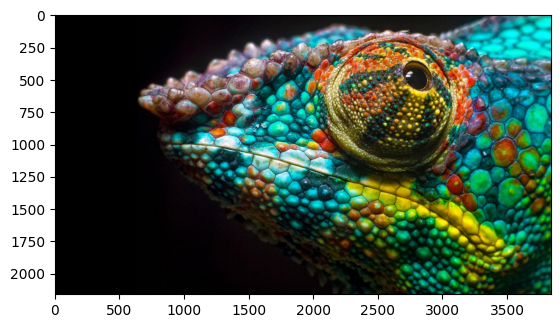

(120, 213)


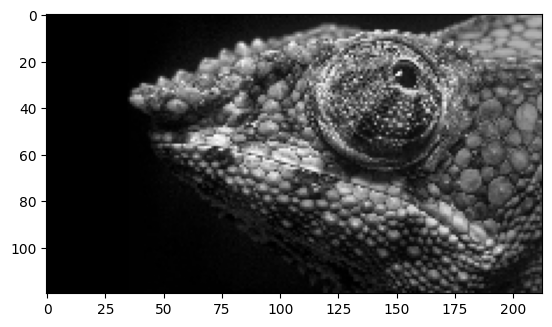

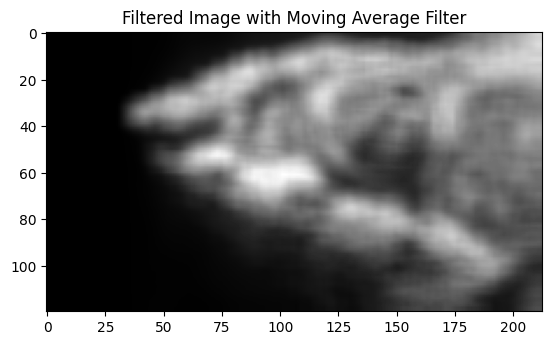

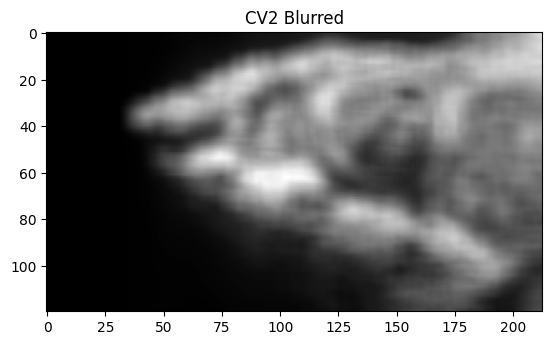

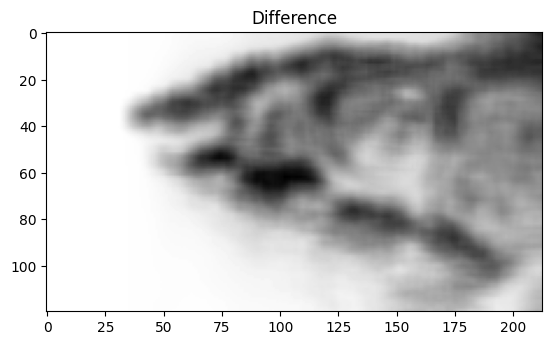

Pytorch FFT: 0.02835988998413086 (Python and C++)
CV2 Blur: 0.00015687942504882812 (Built in C++)
Difference: 0.02820301055908203


In [112]:
import matplotlib.pyplot as plt
import cv2
import torch.nn.functional as F
from time import time

# Load the image using OpenCV
org = cv2.imread('../../images/chameleon.jpg')
plt.imshow(cv2.cvtColor(org, cv2.COLOR_BGR2RGB))
plt.show()

# Convert the image to grayscale
greyorg = cv2.cvtColor(org, cv2.COLOR_BGR2GRAY)

greyorg_resized = cv2.resize(greyorg, (greyorg.shape[1]//18,greyorg.shape[0]//18))
print(greyorg_resized.shape)

plt.imshow(cv2.cvtColor(greyorg_resized,cv2.COLOR_RGB2BGR))
plt.show()

# Convert the grayscale image to a PyTorch tensor
# OpenCV loads images with shape (H, W), but we need to add a batch dimension and channel dimension
input_tensor = torch.tensor(greyorg_resized, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

# Normalize the input tensor to the range [0, 1]
input_tensor = input_tensor / 255.0

# Define a 3x3 moving average filter (all values set to 1/9)
matrsize = 10
moving_average_kernel = torch.ones(1, 1, matrsize, matrsize) / (matrsize*matrsize)

# Initialize the FFTConv2d layer with the moving average kernel
conv_layer = FFTConv2d(in_channels=1, out_channels=1, kernel_size=3, bias=False)

# Set the weight of the convolution layer to the moving average filter
conv_layer.weight.data = moving_average_kernel

if matrsize % 2 == 0:
    padding_left = (matrsize // 2) - 1
    padding_right = matrsize // 2
    padding_top = (matrsize // 2) - 1
    padding_bottom = matrsize // 2
else:
    padding_left = padding_right = padding_top = padding_bottom = (matrsize - 1) // 2

padded_input = F.pad(input_tensor, pad=(padding_left, padding_right, padding_top, padding_bottom), mode='reflect')

# Perform the convolution operation
start = time()
output_tensor = conv_layer(padded_input)
fft_time = time() - start

# Convert the output back to a NumPy array for displaying
output_image = output_tensor.squeeze().detach().numpy()

# Display the output image
plt.imshow(output_image,cmap='gray')
plt.title("Filtered Image with Moving Average Filter")
plt.show()

start = time()
cv2blurred = cv2.blur(greyorg_resized, (matrsize, matrsize))
cv2blur_time = time() - start
plt.imshow(cv2blurred, cmap='gray')
plt.title("CV2 Blurred")
plt.show()

# pad output_image to increase its size to match the original image
plt.imshow(output_image - cv2blurred, cmap='gray')
plt.title("Difference")
plt.show()

print("Pytorch FFT:",fft_time, "(Python and C++)")
print("CV2 Blur:",cv2blur_time,"(Built in C++)")
print("Difference:",fft_time-cv2blur_time)

In [113]:
print(greyorg_resized.shape, output_image.shape)

(120, 213) (120, 213)


### Difference in the outputs:

Both, the FFT implementation and the cv2.blur() libary implementation use the moving average filter as the kernel.

However, there is a difference in the outputs of the two. This can be because of precision errors which arise due to numerical approximations in the FFT, especially when converting back from the frequency domain to the spaicl domain of the image, which can result in small differences in the intensity values of the pixels.

Additionally, differences can arise because of the circular convolution used in the FFT instead of the linear convolution of the spacial moving average filter.